# Traitement automatique des données Poids (Withings HealthMate),
# Food (MyFitnessPal), et Exercices (Polar)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from zipfile import ZipFile

import datetime
import json
import re
import shutil

from tqdm import tqdm

import seaborn as sns

import ipywidgets
import os

In [2]:
# ici, aller chercher dans Download
# les fichiers commençant par data-user... , data_BEN..., etc.
# repérer les plus récents (= derniers downloads)
# et copier ces plus récents dans imports avec le nom qui va bien

# voir :
# os.listdir : liste fichiers
# os.stat_result : donne infos sur fichier x (dont date dernière modif)
# shutil.copy : copie fichier endroit X à l'endroit Y

downloads_rep = "/home/benjamin/Downloads/"
liste_downloaded_files = os.listdir(downloads_rep)

if len(liste_downloaded_files) == 0:
    raise NameError(f"Aucun fichier n'est présent dans {downloads_rep}")

In [3]:
# recherche fichiers POIDS : format data_BEN_xxxxxx.zip

# Source : Withings https://healthmate.withings.com/

# Account > User > Parameters > Download ==> data_BEN_xxxxx.zip ==> contient weight.csv

pattern_poids = "^data_BEN_[\d]+[.]zip"
eng = re.compile(pattern_poids)
liste_zip_poids = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un data_BEN_dddd.zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_poids.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_poids) == 0:
    raise NameError(f'Aucun fichier de type data_BEN_xxxx.zip contenant \
        les données poids ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_poids)

idx = np.argmax(liste_mtime_zips)
filename_poids = liste_zip_poids[idx]

print(f"Le fichier poids le plus récent est : {filename_poids}, parmi :\n")
for f in liste_zip_poids:
    print(f"{f}")

Le fichier poids le plus récent est : data_BEN_1683089784.zip, parmi :

data_BEN_1683089784.zip
data_BEN_1683008936.zip
data_BEN_1682832004.zip
data_BEN_1682743736.zip
data_BEN_1682931449.zip


In [4]:
# recherche fichiers FOOD : format File-Export-YYYY-MM-DD-to-YYYY-MM-DD.zip

# https://www.myfitnesspal.com/reports

# www.myfitnesspal.com ==> reports > export data ==> File-Export-date1-to-date2.zip

pattern_food = "^File-Export-[\d]{4}-[\d]{2}-[\d]{2}-to-[\d]{4}-[\d]{2}-[\d]{2}.*[.]zip"
eng = re.compile(pattern_food)
liste_zip_food = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un File-Export-....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_food.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_food) == 0:
    raise NameError(f'Aucun fichier de type File-Export-xxxx.zip contenant \
        les données food ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_food)

idx = np.argmax(liste_mtime_zips)
filename_food = liste_zip_food[idx]

print(f"Le fichier food le plus récent est : {filename_food}, parmi \n")

for f in liste_zip_food:
    print(f"{f}")

Le fichier food le plus récent est : File-Export-2020-08-03-to-2023-05-03.zip, parmi 

File-Export-2020-08-03-to-2023-05-03.zip
File-Export-2020-08-03-to-2023-04-29.zip
File-Export-2020-08-03-to-2023-05-01.zip
File-Export-2020-08-03-to-2023-05-02.zip
File-Export-2020-08-03-to-2023-04-30.zip


In [5]:
# recherche fichiers EXO par POLAR : format polar-user-data-export.zip

# https://account.polar.com/#export ==> polar-user-data-export-xxxxx.zip

pattern_polar = "^polar-user-data-export_.+[.]zip"
eng = re.compile(pattern_polar)
liste_zip_polar = []
liste_mtime_zips = []

for f in liste_downloaded_files:
    m = eng.search(f)
    if m:  # si on trouve un polar-user-data-export_....zip, on note le nom du fichier et le temps de modif
        filename = m.group(0)
        liste_zip_polar.append(filename)
        mtime = os.stat(downloads_rep + f).st_mtime
        liste_mtime_zips.append(mtime)
        
if len(liste_zip_polar) == 0:
    raise NameError(f'Aucun fichier de type polar-user-data-export_xxxx.zip contenant \
        les données exercices de Polar ne figure dans le répertoire {downloads_rep}')
    
# print(liste_zip_polar)

idx = np.argmax(liste_mtime_zips)
filename_polar = liste_zip_polar[idx]

print(f"Le fichier exercices le plus récent est : {filename_polar}, parmi :\n")

for f in liste_zip_polar:
    print(f"{f}")

Le fichier exercices le plus récent est : polar-user-data-export_30ce1a1f-a9e0-43e2-8d76-0772fbad198f.zip, parmi :

polar-user-data-export_30ce1a1f-a9e0-43e2-8d76-0772fbad198f.zip


In [6]:
# copie les trois fichiers sélectionnés dans le répertoire de travail

import_pathname = '/home/benjamin/Folders_Python/Weight_imports/'

src = [filename_food,
       filename_poids,
       filename_polar]

dst = ['food', 'poids', 'polar']

for s,d in zip(src, dst):
       shutil.copy(downloads_rep + s, import_pathname + d)
       
print(f"Utilise : {filename_food}, {filename_poids}, {filename_polar}")

Utilise : File-Export-2020-08-03-to-2023-05-03.zip, data_BEN_1683089784.zip, polar-user-data-export_30ce1a1f-a9e0-43e2-8d76-0772fbad198f.zip


In [7]:
# Récupère données POIDS

withings_filename = import_pathname + 'poids'  # fichier zip le plus récent de HealthMate Withings

with ZipFile(withings_filename, 'r') as weight_zip:
    weight_csv = weight_zip.extract('weight.csv', path=import_pathname)

# extrait la dataframe poids ----------------

colnames = ['Date', 'Poids (kg)', 'Gras (kg)', 'Masse osseuse (kg)', 'Masse musculaire (kg)', 'Hydratation (kg)']

df_weight = pd.read_csv(weight_csv, usecols=colnames)

os.remove(weight_csv)

df_weight.rename(columns = {'Poids (kg)' : 'Masse_Totale' , 
                            'Gras (kg)' : 'Masse_Grasse',
                            'Masse osseuse (kg)' : 'Masse_Osseuse',
                            'Masse musculaire (kg)' : 'Masse_Musculaire',
                            'Hydratation (kg)' : 'Masse_Hydrique'
                            }, 
                 inplace=True)

# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d %H:%M:%S'

df_weight['Date'] = df_weight['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_weight = df_weight.groupby('Date').mean()

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_weight = df_weight[df_weight.index >= start_date]

subset = ['Masse_Totale', 'Masse_Grasse']
df_weight.dropna(subset = subset, inplace=True)

# df_weight['Masse_Maigre'] = df_weight['Masse_Totale'] - df_weight['Masse_Grasse']
df_weight['MG%'] = df_weight['Masse_Grasse'] / df_weight['Masse_Totale']
df_weight['BMR'] = 370 + 21.6 * (df_weight['Masse_Totale'] - df_weight['Masse_Grasse'])

df_weight.sort_index(inplace=True)

In [8]:
# df_weight

In [9]:
df_weight.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-04-19,71.905000,11.608333,3.016667,57.265000,40.483333,0.161440,1672.408000
2023-04-20,72.091667,11.565000,3.030000,57.480000,40.720000,0.160421,1677.376000
2023-04-21,71.780000,11.940000,2.990000,56.833333,39.981667,0.166342,1662.544000
2023-04-22,72.798571,11.865714,3.048571,57.870000,41.041429,0.162994,1686.149714
2023-04-23,72.972857,11.312857,3.091429,58.552857,41.907143,0.155028,1701.856000
2023-04-24,72.087143,11.885714,3.010000,57.178571,40.335714,0.164880,1670.350857
2023-04-25,72.450000,11.983750,3.022500,57.427500,40.570000,0.165407,1676.071000
2023-04-26,73.171429,12.142857,3.051429,57.958571,41.067143,0.165951,1688.217143
2023-04-27,74.816250,12.818750,3.097500,58.883750,41.845000,0.171336,1709.146000


In [10]:
df_weight.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR
Date,,,,,,,
2023-04-19,72.429286,11.992670,3.021480,57.400272,40.541352,0.165575,1675.430898
2023-04-20,72.323605,11.912772,3.021071,57.374558,40.533801,0.164710,1674.874000
2023-04-21,72.232177,11.868963,3.018690,57.329082,40.496182,0.164315,1673.845429
2023-04-22,72.240068,11.866207,3.019439,57.339558,40.507338,0.164260,1674.075388
2023-04-23,72.310952,11.768282,3.029167,57.498537,40.697168,0.162757,1677.721673
2023-04-24,72.299116,11.749456,3.029524,57.505476,40.707449,0.162523,1677.872653
2023-04-25,72.297891,11.737338,3.029881,57.515323,40.719898,0.162359,1678.107939
2023-04-26,72.478810,11.813699,3.034847,57.614405,40.803299,0.163003,1680.366388
2023-04-27,72.868036,11.992806,3.044490,57.814940,40.964014,0.164563,1684.904959


In [11]:
# Récupère données FOOD

mfp_filename = import_pathname + "food" # données de My Fitness Pal

# Extrait les archives
    
with ZipFile(mfp_filename, 'r') as food_zip:
    output_dir = food_zip.namelist()
    target = 'Nutrition-Summary'
    for l in output_dir:
        if l[:len(target)] == target:
            food_csv = food_zip.extract(l, path=import_pathname)
            break
        
# extrait la dataframe food -------------------------------

colnames = ['Date', 'Meal', 'Calories', 'Fat (g)', 'Carbohydrates (g)', 'Protein (g)']

df_food = pd.read_csv(food_csv, usecols=colnames)
os.remove(food_csv)

df_food.rename(columns = {'Fat (g)' : 'Lipides' , 'Carbohydrates (g)' : 'Glucides', 'Protein (g)' : 'Proteines'}, inplace=True)

In [12]:
# df_food.tail(15)

In [13]:
# transforme le champ str de Date en datetime object

date_format = '%Y-%m-%d'

df_food['Date'] = df_food['Date'].apply(lambda x : datetime.datetime.strptime(x, date_format).date())
df_food = df_food.groupby('Date').sum(numeric_only=True)

start_date = datetime.date(2020, 8, 1)  # on prend les data depuis le 1er Août 2020

df_food = df_food[df_food.index >= start_date]
df_food.dropna(inplace=True)
df_food.sort_index(inplace=True)

In [14]:
df_food.tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-04-18,1803.4,57.8,151.8,168.1
2023-04-19,1705.6,26.9,173.1,191.5
2023-04-20,1679.7,46.1,113.2,206.5
2023-04-21,1940.9,29.0,282.6,140.7
2023-04-22,2632.5,98.0,287.7,147.5
2023-04-23,1604.9,37.4,209.8,106.7
2023-04-24,2037.8,53.7,185.2,194.0
2023-04-25,2101.6,47.4,241.2,169.2
2023-04-26,3416.8,123.4,398.4,151.8


In [15]:
df_food.rolling(window=7).mean().tail(15)

,Calories,Lipides,Glucides,Proteines
Date,,,,
2023-04-18,1777.414286,48.185714,171.542857,162.428571
2023-04-19,1787.714286,45.771429,179.014286,163.814286
2023-04-20,1793.585714,46.885714,174.100000,168.285714
2023-04-21,1824.214286,42.514286,188.314286,170.700000
2023-04-22,1951.771429,46.085714,212.328571,170.200000
2023-04-23,1873.942857,46.371429,199.385714,164.157143
2023-04-24,1914.971429,49.842857,200.485714,165.000000
2023-04-25,1957.571429,48.357143,213.257143,165.157143
2023-04-26,2202.028571,62.142857,245.442857,159.485714


In [16]:
def extract_data_training(exo_dict):
    # utility fonction pour récupérer : date, durée, type exercice et calories dépensées
    
    # récupère date
    pattern = '2(\d){3,3}-(\d){2,2}-(\d){2,2}'  # on cherche une date du type 2xxx-yy-zz
    p = re.compile(pattern)
    m = p.search(exo_dict.get('startTime'))
    if m: 
        time_format = '%Y-%m-%d'
        exo_date = datetime.datetime.strptime( exo_dict.get('startTime')[:10], time_format ).date()
    
    # récupère durée
    pattern = '(\d)+[.]?(\d)*'  # on cherche une durée du type xxxx.yyyy
    p = re.compile(pattern)
    m = p.search(exo_dict.get('duration'))
    if m:
        exo_duration = float(m.group())
    
    # récupère type activité et calories dépensées
    d = exo_dict.get('exercises')[0]   
    exo_type = d.get('sport')
    if d.get('kiloCalories'):
        exo_cals = float(d.get('kiloCalories'))
    else:
        exo_cals = 0.0
    
    return exo_date, exo_duration, exo_type, exo_cals

In [17]:
# Récupère les données EXERCICE

polar_filename = import_pathname + "polar"  # données de Polar

with ZipFile(polar_filename, 'r') as polar_zip:
    output_dir = polar_zip.namelist()
    
    target = 'training-session'
    dict_all_exos = {}
    for i, enr_name in enumerate(tqdm(output_dir)): # on parcourt la liste des archives
        if enr_name[:len(target)] == target:  # si c'est un enregistrement d'une session de training, on traite
            enr_json = polar_zip.extract(enr_name, path=import_pathname)   # extraction du json
            with open(enr_json, 'r') as f:
                exo_dict = json.load(f)
                exo_date, exo_duration, exo_type, exo_cals = extract_data_training(exo_dict)
                if dict_all_exos.get(exo_date) == None:
                    dict_all_exos[exo_date] = [ exo_duration, exo_cals]
                else:
                    dict_all_exos[exo_date] = [ dict_all_exos[exo_date][0] + exo_duration, dict_all_exos[exo_date][1] + exo_cals ]
                # print(f'exercice {i+1} : date = {exo_date}, durée = {exo_duration}, type = {exo_type}, cals = {exo_cals}')
            os.remove(enr_json)
    
    df_exos = pd.DataFrame.from_dict(dict_all_exos, orient='index', columns=['exo_duree', 'exo_cals_bruts']).sort_index()

100%|██████████| 783/783 [00:09<00:00, 80.99it/s]


In [18]:
df_exos.tail(15)

,exo_duree,exo_cals_bruts
2023-03-19,5010.589,442.0
2023-03-20,2940.487,374.0
2023-03-21,3840.000,255.0
2023-03-22,5483.485,396.0
2023-03-24,2482.365,367.0
2023-03-25,5580.836,480.0
2023-03-26,1860.838,241.0
2023-03-28,5344.471,630.0
2023-03-29,1881.342,288.0
2023-03-30,1800.000,120.0


In [19]:
# Ajout à la main des exos depuis le xx Janvier inclus pour palier à la fréquence de rafraîchissement de l'extraction Polar

# récupère fichier brut .csv
exos_persos_filename = "/home/benjamin/Folders_Python/Weight_imports/Exos_Persos.csv"
df_exos_persos = pd.read_csv(exos_persos_filename)

# convertit la colonne Jour en datetime objects en colonne Date
pattern_date = '[\d]{2}/[\d]{2}/[\d]{2}'
p = re.compile(pattern_date)

day_format = "%d/%m/%y"

df_exos_persos['Date'] = df_exos_persos['Jour'].apply( lambda x : datetime.datetime.strptime(p.search(x).group(0), day_format).date() )

# drope la colonne Jour, somme tous les exercices par date
df_exos_persos.drop(columns=['Jour'], inplace=True)

df_exos_persos = df_exos_persos.groupby('Date').sum()

# met au bon format la duree de l'exercice (minutes => secondes)
df_exos_persos['exo_duree'] = df_exos_persos['Duree'] * 60
df_exos_persos.drop(columns=['Duree'], inplace=True)

In [20]:
df_exos_persos

,exo_cals_bruts,exo_duree
Date,,
2023-04-20,0,0
2023-04-21,368,4500
2023-04-22,517,4140
2023-04-23,0,0
2023-04-24,450,4320
2023-04-25,232,2880
2023-04-26,607,6900
2023-04-27,455,5940
2023-04-28,477,4920


In [21]:
# enfin, concatène avec le fichier issu de Polar
df_exos_total = pd.concat( [df_exos, df_exos_persos], axis=0 ).sort_index()

In [22]:
df_exos_total.tail(15)

,exo_duree,exo_cals_bruts
2023-04-03,8130.760,937.0
2023-04-04,5007.299,593.0
2023-04-20,0.000,0.0
2023-04-21,4500.000,368.0
2023-04-22,4140.000,517.0
2023-04-23,0.000,0.0
2023-04-24,4320.000,450.0
2023-04-25,2880.000,232.0
2023-04-26,6900.000,607.0
2023-04-27,5940.000,455.0


In [23]:
df_exos_total.rolling(window=7).mean().tail(15)

,exo_duree,exo_cals_bruts
2023-04-03,4740.306857,504.857143
2023-04-04,4692.139429,499.571429
2023-04-20,4423.376286,458.428571
2023-04-21,4809.090571,493.857143
2023-04-22,4978.703286,488.142857
2023-04-23,4243.216429,426.142857
2023-04-24,3728.294143,409.285714
2023-04-25,2978.185571,308.571429
2023-04-26,3248.571429,310.571429
2023-04-27,4097.142857,375.571429


In [24]:
df_all = pd.concat( [df_weight, df_food, df_exos_total], axis=1 ).sort_index()

# remplace les NaN dans les colonnes exercice par 0.0 : jour sans exercice
df_all['exo_duree'].fillna(0.0, inplace=True)
df_all['exo_cals_bruts'].fillna(0.0, inplace=True)

# drop les jours où il manque des données autres que les exercices
subset = ['Masse_Totale', 'Masse_Grasse', 'Calories']
df_all.dropna(subset = subset, inplace=True)

In [25]:
def exo_cals_nets(bmr, exo_duree, exo_cals_bruts):
    if exo_cals_bruts > 0:
        ecn = exo_cals_bruts - bmr / (24*60*60) * exo_duree
    else:
        ecn = 0.0
        
    return ecn

df_all['exo_cals_nets'] = np.where(df_all['exo_cals_bruts'] > 0, df_all['exo_cals_bruts'] - df_all['BMR'] / (24*60*60) * df_all['exo_duree'], 0 )

In [26]:
df_all['Depense_cal_totale'] = df_all['BMR'] + df_all['exo_cals_nets']
df_all['cal_deficit'] = df_all['Calories'] - (df_all['BMR'] + df_all['exo_cals_nets'])

In [27]:
# df_all.head(20)
# df_all.describe(include='all')
# df_all.info()

In [28]:
df_all.tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-04-18,72.458571,12.068571,3.020000,57.358571,40.482857,0.166558,1674.424000,1803.4,57.8,151.8,168.1,0.0,0.0,0.000000,1674.424000,128.976000
2023-04-19,71.905000,11.608333,3.016667,57.265000,40.483333,0.161440,1672.408000,1705.6,26.9,173.1,191.5,0.0,0.0,0.000000,1672.408000,33.192000
2023-04-20,72.091667,11.565000,3.030000,57.480000,40.720000,0.160421,1677.376000,1679.7,46.1,113.2,206.5,0.0,0.0,0.000000,1677.376000,2.324000
2023-04-21,71.780000,11.940000,2.990000,56.833333,39.981667,0.166342,1662.544000,1940.9,29.0,282.6,140.7,4500.0,368.0,281.409167,1943.953167,-3.053167
2023-04-22,72.798571,11.865714,3.048571,57.870000,41.041429,0.162994,1686.149714,2632.5,98.0,287.7,147.5,4140.0,517.0,436.205326,2122.355040,510.144960
2023-04-23,72.972857,11.312857,3.091429,58.552857,41.907143,0.155028,1701.856000,1604.9,37.4,209.8,106.7,0.0,0.0,0.000000,1701.856000,-96.956000
2023-04-24,72.087143,11.885714,3.010000,57.178571,40.335714,0.164880,1670.350857,2037.8,53.7,185.2,194.0,4320.0,450.0,366.482457,2036.833314,0.966686
2023-04-25,72.450000,11.983750,3.022500,57.427500,40.570000,0.165407,1676.071000,2101.6,47.4,241.2,169.2,2880.0,232.0,176.130967,1852.201967,249.398033
2023-04-26,73.171429,12.142857,3.051429,57.958571,41.067143,0.165951,1688.217143,3416.8,123.4,398.4,151.8,6900.0,607.0,472.177103,2160.394246,1256.405754
2023-04-27,74.816250,12.818750,3.097500,58.883750,41.845000,0.171336,1709.146000,628.6,8.6,110.8,29.6,5940.0,455.0,337.496213,2046.642212,-1418.042213


In [29]:
df_all.rolling(window=7).mean().tail(15)

,Masse_Totale,Masse_Grasse,Masse_Osseuse,Masse_Musculaire,Masse_Hydrique,MG%,BMR,Calories,Lipides,Glucides,Proteines,exo_duree,exo_cals_bruts,exo_cals_nets,Depense_cal_totale,cal_deficit
2023-04-18,72.726786,12.027015,3.035170,57.649558,40.787662,0.165390,1681.115041,1777.414286,48.185714,171.542857,162.428571,0.000000,0.000000,0.000000,1681.115041,96.299245
2023-04-19,72.429286,11.992670,3.021480,57.400272,40.541352,0.165575,1675.430898,1787.714286,45.771429,179.014286,163.814286,0.000000,0.000000,0.000000,1675.430898,112.283388
2023-04-20,72.323605,11.912772,3.021071,57.374558,40.533801,0.164710,1674.874000,1793.585714,46.885714,174.100000,168.285714,0.000000,0.000000,0.000000,1674.874000,118.711714
2023-04-21,72.232177,11.868963,3.018690,57.329082,40.496182,0.164315,1673.845429,1824.214286,42.514286,188.314286,170.700000,642.857143,52.571429,40.201310,1714.046738,110.167548
2023-04-22,72.240068,11.866207,3.019439,57.339558,40.507338,0.164260,1674.075388,1951.771429,46.085714,212.328571,170.200000,1234.285714,126.428571,102.516356,1776.591744,175.179685
2023-04-23,72.310952,11.768282,3.029167,57.498537,40.697168,0.162757,1677.721673,1873.942857,46.371429,199.385714,164.157143,1234.285714,126.428571,102.516356,1780.238030,93.704828
2023-04-24,72.299116,11.749456,3.029524,57.505476,40.707449,0.162523,1677.872653,1914.971429,49.842857,200.485714,165.000000,1851.428571,190.714286,154.870993,1832.743646,82.227783
2023-04-25,72.297891,11.737338,3.029881,57.515323,40.719898,0.162359,1678.107939,1957.571429,48.357143,213.257143,165.157143,2262.857143,223.857143,180.032560,1858.140498,99.430930
2023-04-26,72.478810,11.813699,3.034847,57.614405,40.803299,0.163003,1680.366388,2202.028571,62.142857,245.442857,159.485714,3248.571429,310.571429,247.486431,1927.852819,274.175752
2023-04-27,72.868036,11.992806,3.044490,57.814940,40.964014,0.164563,1684.904959,2051.871429,56.785714,245.100000,134.214286,4097.142857,375.571429,295.700176,1980.605135,71.266293


# Graphes

In [30]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

dict_hlines = {
        'Calories' : [ (1500, 'green'), (1800, 'orange'), (2000, 'red') ],
        'cal_deficit' : [ (-500, 'green'), (-200, 'orange'), (200, 'red' ) ],
        'MG%' : [ (.12, 'green'), (.14, 'orange'), (.16,'red') ]
    }

In [31]:
def plot_general(longueur=15,
                 year=2023,
                 month=1,
                 day=1,
                #  vars = vars,
                #  dict_hlines = dict_hlines
):
    
    # vars = ['Masse_Totale', 'MG%', 'Calories', 'Depense_cal_totale', 'cal_deficit'] # 'Masse_Grasse', 'BMR',
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    for v in vars:
        fig, ax = plt.subplots(figsize=(10,4))

        ax = sns.lineplot(data=df_all2, x=df_all2.index, y=v)
        ax.set_title(f"{v} (moyennes {longueur}j)") 
        ax.grid()
        ax.tick_params(axis='x', labelrotation=60)
        
        if v in dict_hlines:
            list_to_display = dict_hlines.get(v)
            for t in list_to_display:
                val = t[0]
                col = t[1]
                ax.axhline(y=val, color=col, lw=2.0)
        
    plt.plot()

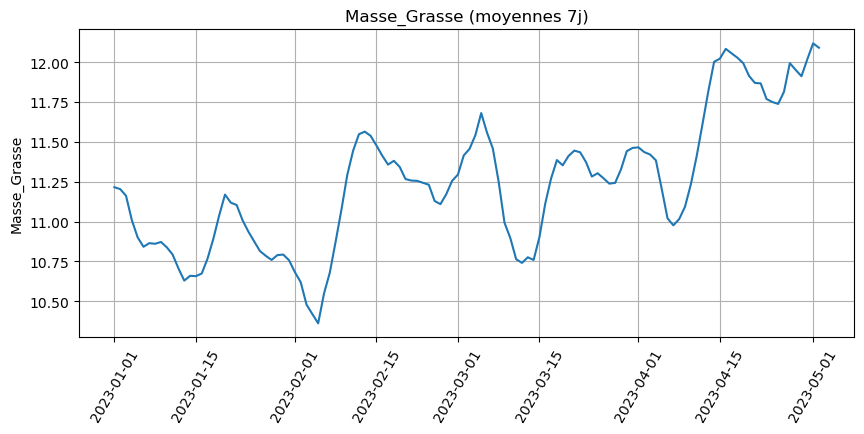

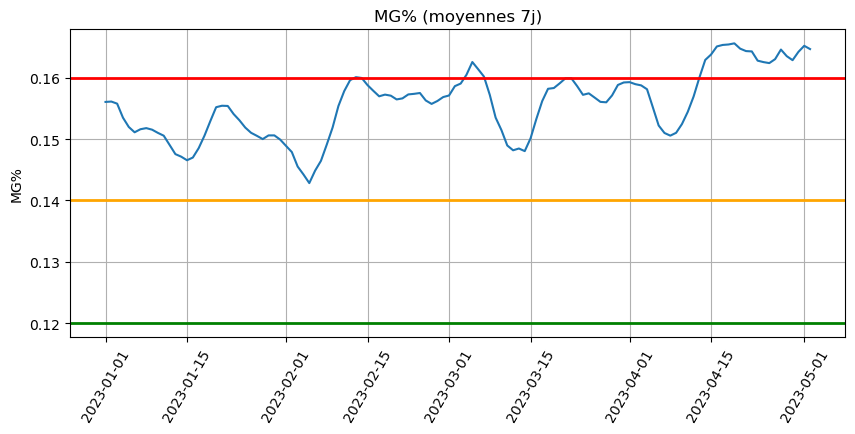

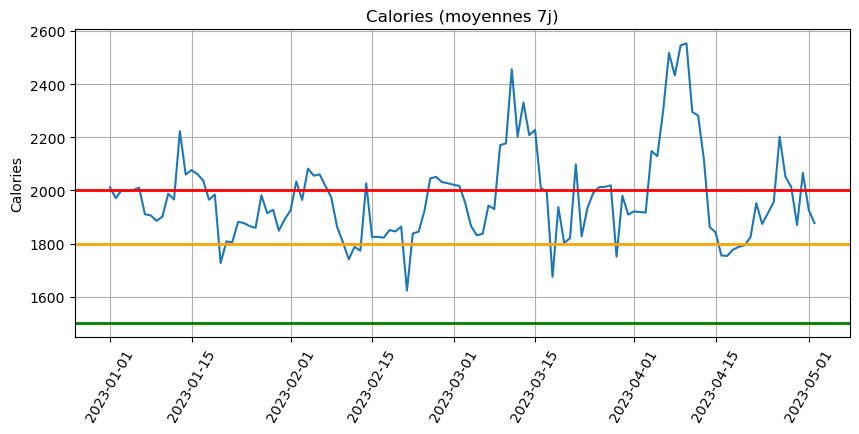

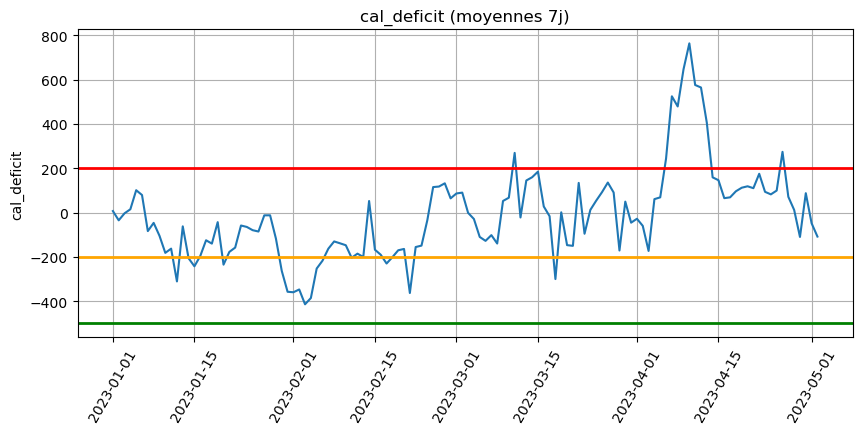

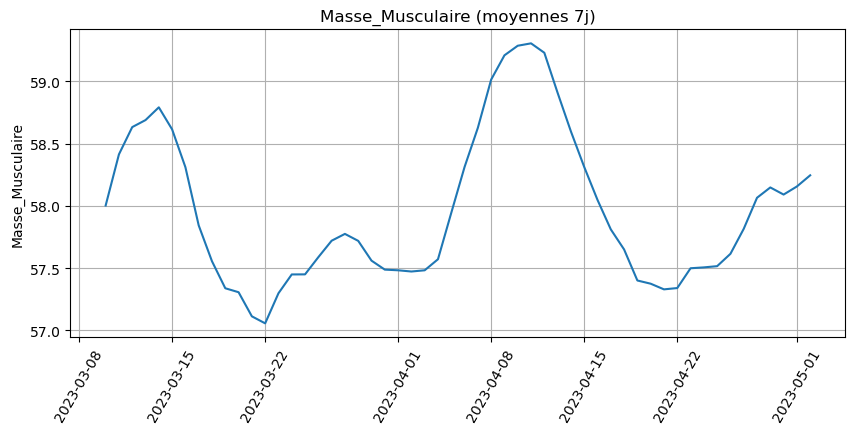

In [32]:
plot_general(longueur=7)

In [33]:
vars = ['Masse_Grasse', 'MG%', 'Calories', 'cal_deficit', 'Masse_Musculaire'] # 'Masse_Grasse', 'BMR', 'Masse_Totale', 'exo_cals_nets', 'Masse_Musculaire', 

ipywidgets.interact(plot_general, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2023…

<function __main__.plot_general(longueur=15, year=2023, month=1, day=1)>

In [34]:
def plot_general2(longueur=15,
                 year=2022,
                 month=11,
                 day=1,
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.11, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['cal_deficit']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('cal_deficit')
    ax2.set_ylim(bottom=-400.0, top=500.0)
    # ax2.legend()

In [35]:
ipywidgets.interact(plot_general2, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2022…

<function __main__.plot_general2(longueur=15, year=2022, month=11, day=1)>

In [36]:
def plot_general3(longueur=15,
                 year=2022,
                 month=11,
                 day=1
):
    # vars = ['Masse_Totale', 'MG%', 'BMR', 'Calories', 'cal_deficit']
    
    subset = ['Masse_Totale', 'Masse_Grasse'] # on permet des NaN en masse osseuse, etc en attendant d'avoir des data
    df_all2 = df_all.rolling(longueur).mean().dropna(subset = subset)
    start_date = datetime.date(year=year, month=month, day=day)

    df_all2 = df_all2[df_all2.index >= start_date]

    fig, ax = plt.subplots(figsize=(12,5))
    
    x = df_all2.index
    y1 = df_all2['MG%']
    ax.plot(y1, marker='.', color='red', label='MG%')
    ax.set_ylabel('MG%')
    ax.set_ylim(bottom=0.11, top=0.17)
    ax.tick_params(axis='x', labelrotation=60)
    ax.legend()
    ax.grid()
    
    y2 = df_all2['Calories']
    ax2 = ax.twinx()
    ax2.plot(y2, marker='.', color='blue', label='cal_deficit')
    ax2.set_ylabel('Calories')
    ax2.set_ylim(bottom=1700.0, top=2500.0)
    # ax2.legend()

In [37]:
ipywidgets.interact(plot_general3, longueur=(1,90,7), year=(2020,2023,1), month=(1,12,1), day=(1))

interactive(children=(IntSlider(value=15, description='longueur', max=90, min=1, step=7), IntSlider(value=2022…

<function __main__.plot_general3(longueur=15, year=2022, month=11, day=1)>